# Deep Learning With Python: 5.3
**Introdução a Deep-Learning | Aplicações em Visão Computacional**

<br>

---

### Tópico Abordado:
* Using a pretrained convnet

---

# Pretrained Network
* Uma rede neural salva que foi anteriormente treinada em um grande conjunto de dados.

**Requisitos:**
* Conjunto Grande
* Conjunto Genérico

**Características:**
* Hierarquia Espacial

**Métodos:**
* Feature Extraction
* Fine Tunning

## Feature Extraction
* Usar *features* de uma rede já treinada para treinar uma nova.

## Fine Tunning
* Ferramenta complementar a *Feature Extraction*
* Descongelar as últimas camadas da *convbase* 

In [0]:
import os
import numpy as np
import random
import tensorflow as tf
from keras import backend as K

import shutil
from google.colab import drive
import zipfile

from keras.applications import VGG16

from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import optimizers

from keras.callbacks import CSVLogger
import pandas as pd

In [0]:
# Reprodutibilidade
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

os.environ['PYTHONHASHSEED'] = '12'
np.random.seed(123)
random.seed(1234)
tf.set_random_seed(12345)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
#                               inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

print('Sementes Plantadas!')

Sementes Plantadas!


In [0]:
# Montando Google Drive

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
TRAIN_MODELS = False

In [0]:
class DataHandler:
  def __init__(self, folder):
    self.source_file = '/gdrive/My Drive/ml_datasets/dogs_vs_cats.zip'
    self.root_dir = '/content/data'
    self.base_dir = os.path.join(self.root_dir, folder)
    self.train_dir = os.path.join(self.base_dir, 'train')
    self.train_cats_dir = os.path.join(self.train_dir, 'cats')
    self.train_dogs_dir = os.path.join(self.train_dir, 'dogs')
    self.val_dir = os.path.join(self.base_dir, 'validation')
    self.val_cats_dir = os.path.join(self.val_dir, 'cats')
    self.val_dogs_dir = os.path.join(self.val_dir, 'dogs')
    self.test_dir = os.path.join(self.base_dir, 'test')
    self.test_cats_dir = os.path.join(self.test_dir, 'cats')
    self.test_dogs_dir = os.path.join(self.test_dir, 'dogs')
  
  def __config_dir_struct(self):
    if (not os.path.exists(self.root_dir)):
      os.mkdir(self.root_dir)

    try:
      shutil.rmtree(self.base_dir)
      print('Diretório de dados limpo')
    except:
      pass

    os.mkdir(self.base_dir)
    os.mkdir(self.train_dir)
    os.mkdir(self.train_cats_dir)
    os.mkdir(self.train_dogs_dir)
    os.mkdir(self.val_dir)
    os.mkdir(self.val_cats_dir)
    os.mkdir(self.val_dogs_dir)
    os.mkdir(self.test_dir)
    os.mkdir(self.test_cats_dir)
    os.mkdir(self.test_dogs_dir)

  def extract(self, train_samples=0, val_samples=0, test_samples=0):
    self.__config_dir_struct()
    self.train_samples = train_samples
    self.val_samples = val_samples
    self.test_samples = test_samples

    def move_to_parent(root, child):
      for f in os.listdir(os.path.join(root, child)):
        shutil.move(
            os.path.join(root, child, f),
            root
        )
      os.rmdir(os.path.join(root, child))

    print('Iniciando descompressões')

    if (not os.path.exists(os.path.join(self.root_dir, 'train.zip'))):
      with zipfile.ZipFile(self.source_file, 'r') as zip_ref:
        zip_ref.extract('train.zip', path=self.root_dir)
        print('Conjunto de treinamento OK!')

    with zipfile.ZipFile(os.path.join(self.root_dir, 'train.zip'), 'r') as zip_ref:
      start = 0
      end = train_samples
      for i in range(start, end):
        zip_ref.extract('train/cat.{}.jpg'.format(i), path=self.train_cats_dir)
        zip_ref.extract('train/dog.{}.jpg'.format(i), path=self.train_dogs_dir)
      move_to_parent(self.train_cats_dir, 'train')
      move_to_parent(self.train_dogs_dir, 'train')
      print('Subconjunto de treinamento OK!')
      
      start = end
      end = train_samples + val_samples
      for i in range(start, end):
        zip_ref.extract('train/cat.{}.jpg'.format(i), path=self.val_cats_dir)
        zip_ref.extract('train/dog.{}.jpg'.format(i), path=self.val_dogs_dir)
      move_to_parent(self.val_cats_dir, 'train')
      move_to_parent(self.val_dogs_dir, 'train')
      print('Subconjunto de validação OK!')

      start = end
      end = train_samples + val_samples + test_samples
      for i in range(start, end):
        zip_ref.extract('train/cat.{}.jpg'.format(i), path=self.test_cats_dir)
        zip_ref.extract('train/dog.{}.jpg'.format(i), path=self.test_dogs_dir)
      move_to_parent(self.test_cats_dir, 'train')
      move_to_parent(self.test_dogs_dir, 'train')
      print('Subconjunto de teste OK!')

In [0]:
class Model:
  def __init__(self, name):
    self.model = None
    self.history = None
    self.model_file = '/gdrive/My Drive/ml_fits/cats_dogs_2_{}.h5'.format(name)
    self.history_file = '/gdrive/My Drive/ml_fits/cats_dogs_2_{}.csv'.format(name)
    self.conv_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )
    self.conv_base.trainable = False
  
  def extract_features(self, directory, sample_count):
    datagen = ImageDataGenerator(rescale=1./255)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        shuffle=True,
        seed=1234
    )
    batch_size = 20
    i = 0
    for inputs_batch, labels_batch in generator:
      features_batch = self.conv_base.predict(inputs_batch)
      features[i * batch_size : (i + 1) * batch_size] = features_batch
      labels[i * batch_size : (i + 1) * batch_size] = labels_batch
      i += 1
      if i * batch_size >= sample_count:
        break
    return features, labels

  def preprocess(self, data_handler):
    self.train_features, self.train_labels = self.extract_features(
        data_handler.train_dir, 
        data_handler.train_samples
    )
    self.val_features, self.val_labels = self.extract_features(
        data_handler.val_dir,
        data_handler.val_samples
    )
    self.test_features, self.test_labels = self.extract_features(
        data_handler.test_dir,
        data_handler.test_samples
    )

    self.train_features = np.reshape(
        self.train_features, 
        (data_handler.train_samples, 4 * 4 * 512)
    )
    self.val_features = np.reshape(
        self.val_features,
        (data_handler.val_samples, 4 * 4 * 512)
    )
    self.test_features = np.reshape(
        self.test_features,
        (data_handler.test_samples, 4 * 4 * 512)
    )

  def compile_model(self):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                  loss='binary_crossentropy',
                  metrics=['acc']
    )
    
    self.model = model

  def fit(self):
    csv_logger = CSVLogger(self.history_file, separator=',', append=False)
    
    self.model.fit(
        self.train_features,
        self.train_labels,
        epochs=30,
        batch_size=20,
        validation_data=(self.val_features, self.val_labels),
        callbacks=[csv_logger]
    )
    
    self.model.save(self.model_file)
    self.history = pd.read_csv(self.history_file, sep=',', engine='python')
    

  def load_model(self):
    self.model = models.load_model(self.model_file)
    self.history = pd.read_csv(self.history_file, sep=',', engine='python')

In [0]:
dh = DataHandler('subset')
dh.extract(1000, 500, 500)

m = Model('subset')
m.preprocess(dh)
if (TRAIN_MODELS):
  m.compile_model()
  m.fit()
else:
  m.load_model()

Diretório de dados limpo
Iniciando descompressões
Subconjunto de treinamento OK!
Subconjunto de validação OK!
Subconjunto de teste OK!
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


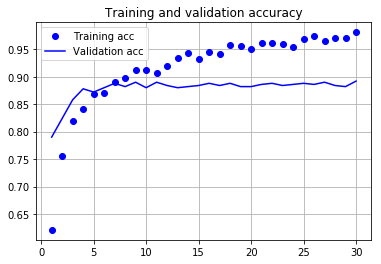

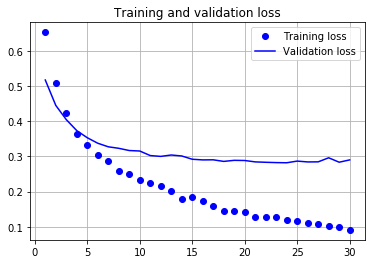

In [0]:
acc = m.history['acc']
val_acc = m.history['val_acc']
loss = m.history['loss']
val_loss = m.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [0]:
class DataAugModel:
  def __init__(self, name):
    self.model = None
    self.history = None
    self.model_file = '/gdrive/My Drive/ml_fits/cats_dogs_2_{}.h5'.format(name)
    self.history_file = '/gdrive/My Drive/ml_fits/cats_dogs_2_{}.csv'.format(name)
    self.train_datagen = None
    self.val_datagen = None
    self.conv_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )
    self.conv_base.trainable = False
  
  def extract_features(self, directory, sample_count):
    datagen = ImageDataGenerator(rescale=1./255)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        shuffle=True,
        seed=1234
    )
    batch_size = 20
    i = 0
    for inputs_batch, labels_batch in generator:
      features_batch = self.conv_base.predict(inputs_batch)
      features[i * batch_size : (i + 1) * batch_size] = features_batch
      labels[i * batch_size : (i + 1) * batch_size] = labels_batch
      i += 1
      if i * batch_size >= sample_count:
        break
    return features, labels

  def preprocess(self, data_handler):
    self.train_features, self.train_labels = self.extract_features(
        data_handler.train_dir, 
        data_handler.train_samples
    )
    self.val_features, self.val_labels = self.extract_features(
        data_handler.val_dir,
        data_handler.val_samples
    )
    self.test_features, self.test_labels = self.extract_features(
        data_handler.test_dir,
        data_handler.test_samples
    )

    self.train_features = np.reshape(
        self.train_features, 
        (data_handler.train_samples, 4 * 4 * 512)
    )
    self.val_features = np.reshape(
        self.val_features,
        (data_handler.val_samples, 4 * 4 * 512)
    )
    self.test_features = np.reshape(
        self.test_features,
        (data_handler.test_samples, 4 * 4 * 512)
    )
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    self.train_generator = train_datagen.flow_from_directory(
        data_handler.train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary'
    )
    
    self.val_generator = test_datagen.flow_from_directory(
        data_handler.val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary'
    )

  def compile_model(self):
    model = models.Sequential()
    model.add(self.conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=optimizers.RMSprop(lr=2e-5),
        loss='binary_crossentropy',
        metrics=['acc']
    )
    
    self.model = model

  def fit(self):
    csv_logger = CSVLogger(self.history_file, separator=',', append=False)
    
    self.model.fit_generator(
        self.train_generator,
        epochs=30,
        steps_per_epoch=100,
        validation_data=self.val_generator,
        validation_steps=50,
        callbacks=[csv_logger]
    )
    
    self.model.save(self.model_file)
    self.history = pd.read_csv(self.history_file, sep=',', engine='python')
    

  def load_model(self):
    self.model = models.load_model(self.model_file)
    self.history = pd.read_csv(self.history_file, sep=',', engine='python')

In [0]:
m2 = DataAugModel('subset2')
m2.preprocess(dh)
if (TRAIN_MODELS):
  m2.compile_model()
  m2.fit()
else:
  m2.load_model()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


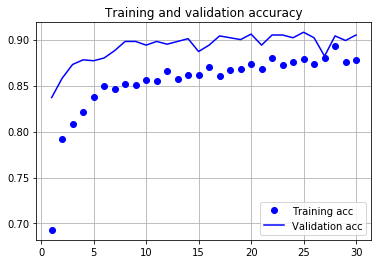

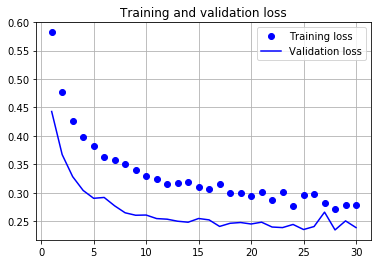

In [0]:
acc = m2.history['acc']
val_acc = m2.history['val_acc']
loss = m2.history['loss']
val_loss = m2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()